# Simple load collection example: ESA WorldCover


This notebook is a simple example of how to load the ESA WorldCover dataset using the `load_collection` function from the `openeo` Python package. Here we will load the ESA WorldCover dataset for the year 2021 apply simple UDF and visualize the result.

In [1]:
import openeo
import json
import folium
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# connect to the federated backend
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


List the available collections from the backend and fetch its description.

In [2]:
connection.list_collection_ids()

['SENTINEL3_OLCI_L1B',
 'SENTINEL3_SLSTR',
 'SENTINEL_5P_L2',
 'COPERNICUS_VEGETATION_PHENOLOGY_PRODUCTIVITY_10M_SEASON1',
 'COPERNICUS_VEGETATION_PHENOLOGY_PRODUCTIVITY_10M_SEASON2',
 'COPERNICUS_PLANT_PHENOLOGY_INDEX',
 'ESA_WORLDCOVER_10M_2020_V1',
 'ESA_WORLDCOVER_10M_2021_V2',
 'COPERNICUS_VEGETATION_INDICES',
 'SENTINEL2_L1C',
 'SENTINEL2_L2A',
 'SENTINEL1_GRD',
 'COPERNICUS_30',
 'LANDSAT8_L2',
 'SENTINEL3_SYN_L2_SYN',
 'SENTINEL3_SLSTR_L2_LST',
 'SENTINEL1_GLOBAL_MOSAICS']

In [3]:
connection.describe_collection("ESA_WORLDCOVER_10M_2021_V2")

{'assets': {},
 'cube:dimensions': {'bands': {'type': 'bands', 'values': ['MAP']},
  't': {'extent': ['2023-04-27T06:38:05Z', '2024-04-25T06:38:05Z'],
   'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180.0, 180.0],
   'step': 8.3333333333e-05,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-90.0, 90.0],
   'step': 8.3333333333e-05,
   'type': 'spatial'}},
 'description': 'WorldCover provides global land cover products for 2021 at 10 m resolution, developed and validated in near-real time based on Sentinel-1 and Sentinel-2 data. ',
 'experimental': True,
 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
  'temporal': {'interval': [['2023-04-27T06:38:05Z',
     '2024-04-25T06:38:05Z']]}},
 'id': 'ESA_WORLDCOVER_10M_2021_V2',
 'item_assets': {'MAP': {'description': 'classification band',
   'eo:bands': [{'description': 'Classification', 'name': 'MAP'}],
   'roles': ['data'],
   'title': 'MAP',
   'type': 'image/tiff; application=geotiff'}},
 'keywords': ['VITO',
  'COPERNICUS',
  'ESA',
  'Land Cover',
  'Sentinel-1',
  'Sentinel-2',
  'Environment',
  'WorldCover'],
 'license': 'CC-BY-4.0',
 'links': [{'href': 'https://esa-worldcover.org/',
   'rel': 'alternate',
   'title': 'Product website'},
  {'href': 'https://services.terrascope.be/catalogue/description?collection=urn:eop:VITO:ESA_WorldCover_10m_2021_V2',
   'rel': 'alternate',
   'title': 'EO OpenSearch catalog'},
  {'href': 'https://viewer.esa-worldcover.org/worldcover',
   'rel': 'alternate',
   'title': 'Product Viewer'},
  {'href': 'https://services.terrascope.be/wmts/v2',
   'rel': 'wmts',
   'wmts:layer': 'WORLDCOVER_2021_MAP'},
  {'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.2/collections',
   'rel': 'root'},
  {'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.2/collections',
   'rel': 'parent'},
  {'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.2/collections/ESA_WORLDCOVER_10M_2021_V2',
   'rel': 'self'}],
 'providers': [{'name': 'VITO',
   'roles': ['producer'],
   'url': 'https://remotesensing.vito.be/'},
  {'name': 'ESA', 'roles': ['licensor'], 'url': 'https://esa.int/'}],
 'stac_extensions': ['https://stac-extensions.github.io/item-assets/v1.0.0/schema.json',
  'https://stac-extensions.github.io/raster/v1.1.0/schema.json',
  'https://stac-extensions.github.io/classification/v1.0.0/schema.json'],
 'stac_version': '1.0.0',
 'summaries': {'eo:bands': [{'gsd': 10, 'name': 'MAP', 'type': 'uint8'}]},
 'title': 'Global landcover at 10m resolution for 2021.',
 'type': 'Collection'}

In [4]:
# define aoi and temporal extent
def read_json(filename: str) -> dict:
    with open(filename) as input:
        field = json.load(input)
    return field


dates = ["2021-01-01", "2021-12-31"]
aoi = read_json("aoi/Antwerp.geojson")

In [5]:
m = folium.Map([51.18, 4.5], zoom_start=11)
folium.GeoJson(aoi).add_to(m)
m

In [6]:
# load data from the CDSE backend
cube = connection.load_collection(
    "ESA_WORLDCOVER_10M_2021_V2", temporal_extent=dates, spatial_extent=aoi
)

In [7]:
# let us apply a simple rescaling udf

udf = openeo.UDF(
    """
import xarray

def apply_datacube(cube: xarray.DataArray, context: dict) -> xarray.DataArray:
    cube.values = 0.8 * cube.values
    return cube
"""
)

Users can also load the UDF from a python file directly, instead of defining it as a string. For more information, please refer to the [openEO UDF documentation](https://open-eo.github.io/openeo-python-client/udf.html).

In [8]:
rescaled_cube = cube.apply(process=udf)

In [9]:
rescaled_cube

In [11]:
# job configuration

job_options = {
    "executor-memory": "2G",
    "executor-memoryOverhead": "3G",
    "python-memory": "3G",
}
# running a batch job

rescaled_cube.execute_batch(
    title="ESA_WORLDCOVER_10M_2021_V2",
    outputfile="ESAWorldCover.nc",
    job_options=job_options,
)

0:00:00 Job 'j-250210143617487282010f406a25f544': send 'start'
0:00:14 Job 'j-250210143617487282010f406a25f544': created (progress 0%)
0:00:19 Job 'j-250210143617487282010f406a25f544': created (progress 0%)
0:00:26 Job 'j-250210143617487282010f406a25f544': created (progress 0%)
0:00:34 Job 'j-250210143617487282010f406a25f544': created (progress 0%)
0:00:44 Job 'j-250210143617487282010f406a25f544': created (progress 0%)
0:00:56 Job 'j-250210143617487282010f406a25f544': running (progress N/A)
0:01:12 Job 'j-250210143617487282010f406a25f544': running (progress N/A)
0:01:31 Job 'j-250210143617487282010f406a25f544': running (progress N/A)
0:01:55 Job 'j-250210143617487282010f406a25f544': running (progress N/A)
0:02:25 Job 'j-250210143617487282010f406a25f544': running (progress N/A)
0:03:03 Job 'j-250210143617487282010f406a25f544': finished (progress 100%)


<BatchJob job_id='j-250210143617487282010f406a25f544'>


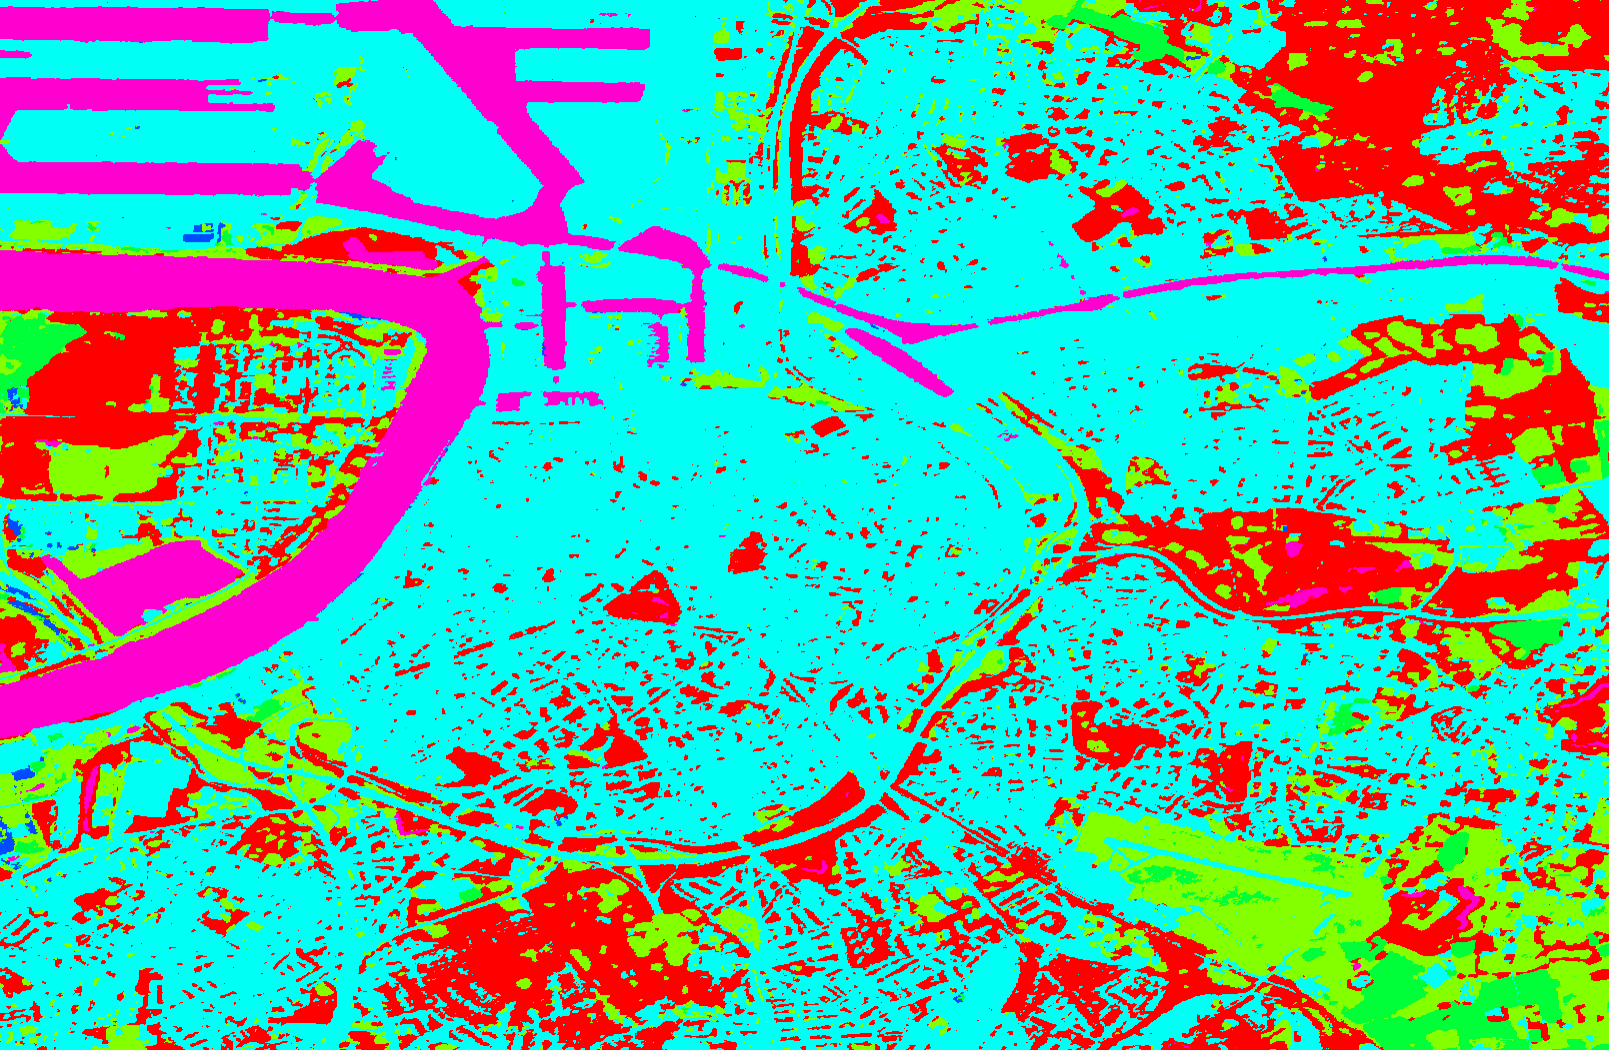

In [12]:
# visualize the result

ds = xr.open_dataset("ESAWorldCover.nc")
data = ds[["MAP"]].to_array(dim="bands").squeeze()
# Replace zeros with NaN
arr = data.values
arr[arr == 0] = np.nan

# Generate lat/lon grid
lon, lat = np.meshgrid(
    data.x.values.astype(np.float64), data.y.values.astype(np.float64)
)

# Normalize data using a thematic color scale
cmap = plt.get_cmap("hsv")  # Choose a thematic colormap
norm = mcolors.Normalize(vmin=np.nanmin(arr), vmax=np.nanmax(arr))  # Scale values
colored_data = cmap(norm(arr))  # Convert data to RGBA colors

# Ensure correct shape (H, W, 4)
colored_data = (colored_data[:, :, :4] * 255).astype(
    np.uint8
)  # Convert to uint8 format

# Create Folium map
m = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=12)

folium.raster_layers.ImageOverlay(
    image=colored_data,
    bounds=[[lat.min(), lon.min()], [lat.max(), lon.max()]],
    mercator_project=True,
    opacity=0.7,
).add_to(m)

m